In [2]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
import requests
import yfinance as yf
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
#from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

In [3]:
#read csv data from IPO Scoop into a dataframe and set the company Symbol as the index
#other columns include industry type, amount of shares in millions, initial offer price, closing on the first day
#current price and returns, and then dropping the 1st day close column
ipo_csv = pd.read_csv('IpoScoop2018+.csv')
filtered_ipo=ipo_csv.drop(columns=["1st Day Close"])
filtered_ipo.set_index('Symbol',inplace=True)

<AxesSubplot:ylabel='Industry'>

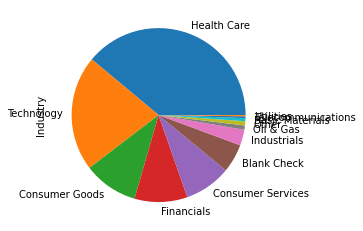

In [4]:
#visualization of different industries
sector_count = filtered_ipo["Industry"].value_counts()
sector_count.plot(kind="pie")

In [5]:
filtered_ipo["Offer Date"]=pd.to_datetime(filtered_ipo["Offer Date"], infer_datetime_format=True)
filter_ipo = filtered_ipo.drop(['MTAL.U', 'TPGS', 'KVSB', 'STRE.U', 'SCR', 'FWAA', 'HCAQ', 'TBA.U', 'HFEN', 'FSDC', 'ARYA', 'PAND', 'TXAC', 'HECCU', 'CSPR', 'PPD', 'DNK', 'VIE', 'HKIB', 'WSG', 'LVGO', 'PROS', 'MDLA', 'PRVL', 'PRVL', 'PRVL', 'MWK', 'GSX', 'RUHN', 'FHL', 'AVDR', 'THOR', 'OSMT', 'UROV', 'SVMK', 'PRNB', 'CNST'])
filter_ipo

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return
Symbol,,,,,,,
BLTE,"Belite Bio, Inc.",Health Care,2022-04-29,6.0,$6.00,$10.59,76.50%
HLVX,"HilleVax, Inc.",Health Care,2022-04-29,11.8,$17.00,$19.09,12.29%
OST,"Ostin Technology Group Co., Ltd.",Industrials,2022-04-27,3.4,$4.00,$3.70,-7.50%
TNON,"Tenon Medical, Inc.",Health Care,2022-04-27,3.2,$5.00,$21.61,332.20%
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$4.35,8.75%
...,...,...,...,...,...,...,...
TLRY,Tilray,Health Care,2018-07-19,9.0,$17.00,$46.56,173.88%
CCB,Coastal Financial,Financials,2018-07-18,2.9,$14.50,$15.47,6.69%
CRNX,Crinetics Pharmaceuticals,Health Care,2018-07-18,6.0,$17.00,$25.00,47.06%


In [6]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
ten_days = pd.to_timedelta(10,'days')
three_months = pd.to_timedelta(84,'days')
hundred_days = pd.to_timedelta(100,'days')
filter_ipo['T-10Days'] = filter_ipo['Offer Date']-ten_days
filter_ipo['T-90Days'] = filter_ipo['Offer Date']-three_months
filter_ipo['T+100Days'] = filter_ipo['Offer Date']+hundred_days

In [7]:
#convert to string for yf useage
filter_ipo['T-10Days'] = filter_ipo['T-10Days'].astype(str)
filter_ipo['T-90Days'] = filter_ipo['T-90Days'].astype(str)
filter_ipo['T+100Days'] = filter_ipo['T+100Days'].astype(str)

In [8]:
#spy_returns_ALL = yf.download("SPY","2018-06-01")
#spy_returns_ALL

In [9]:
#test_spy_1 = spy_returns_ALL.loc[filter_ipo.loc["BLTE",'T-90Days']: filter_ipo.loc["BLTE",'T-10Days']]


In [10]:
#test_spy_1.iloc[0]

In [11]:
#test_spy_2.iloc[0]

In [12]:
#test_spy_2 = yf.download("SPY",filter_ipo.loc["BLTE",'T-90Days'], filter_ipo.loc["BLTE",'T-10Days'],progress=True)

In [13]:
#test_spy_2

In [14]:
#filter_ipo2 = filter_ipo.copy()

In [15]:
#for ticker in filter_ipo2.index:
#    data3 = spy_returns_ALL.loc[filter_ipo2.loc[ticker,'T-90Days']:filter_ipo2.loc[ticker,'T-10Days']]# [start: end] dates
#    spy_return = (data3.iloc[-1,-2] - data3.iloc[0,-2])/data3.iloc[0,-2]
#    filter_ipo2.loc[ticker,'SPY 90D Return'] = spy_return
#    print(ticker)
#    data2=yf.download(ticker,filter_ipo2.loc[ticker,'Offer Date'], filter_ipo2.loc[ticker,'T+100Days'],progress=True)
#    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
#    filter_ipo2.loc[ticker,'100 day Return'] = stock_return

In [16]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
for ticker in filter_ipo.index:
    data=yf.download("SPY",filter_ipo.loc[ticker,'T-90Days'], filter_ipo.loc[ticker,'T-10Days'],progress=True)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    filter_ipo.loc[ticker,'SPY 90D Return'] = spy_return
    print(ticker)
    data2=yf.download(ticker,filter_ipo.loc[ticker,'Offer Date'], filter_ipo.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo.loc[ticker,'100 day Return'] = stock_return

[*********************100%***********************]  1 of 1 completed
BLTE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
HLVX
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
OST
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
TNON
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
JCSE
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
APLD
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
EE
[*********************100%***********************]  1 of 1 completed
[*

In [17]:
#save data into a file to a file 

In [18]:
#checking output
display(filter_ipo)


,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return,T-10Days,T-90Days,T+100Days,SPY 90D Return,100 day Return
Symbol,,,,,,,,,,,,
BLTE,"Belite Bio, Inc.",Health Care,2022-04-29,6.0,$6.00,$10.59,76.50%,2022-04-19,2022-02-04,2022-08-07,-0.020881,-0.162417
HLVX,"HilleVax, Inc.",Health Care,2022-04-29,11.8,$17.00,$19.09,12.29%,2022-04-19,2022-02-04,2022-08-07,-0.020881,0.050812
OST,"Ostin Technology Group Co., Ltd.",Industrials,2022-04-27,3.4,$4.00,$3.70,-7.50%,2022-04-17,2022-02-02,2022-08-05,-0.039794,-0.923853
TNON,"Tenon Medical, Inc.",Health Care,2022-04-27,3.2,$5.00,$21.61,332.20%,2022-04-17,2022-02-02,2022-08-05,-0.039794,0.130667
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$4.35,8.75%,2022-04-12,2022-01-28,2022-07-31,-0.001501,-0.774737
...,...,...,...,...,...,...,...,...,...,...,...,...
TLRY,Tilray,Health Care,2018-07-19,9.0,$17.00,$46.56,173.88%,2018-07-09,2018-04-26,2018-10-27,0.038852,3.827155
CCB,Coastal Financial,Financials,2018-07-18,2.9,$14.50,$15.47,6.69%,2018-07-08,2018-04-25,2018-10-26,0.049413,-0.053383
CRNX,Crinetics Pharmaceuticals,Health Care,2018-07-18,6.0,$17.00,$25.00,47.06%,2018-07-08,2018-04-25,2018-10-26,0.049413,0.019992


In [19]:
# Encode Offer Date to week of year
for ticker in filter_ipo.index:
    filter_ipo.loc[ticker,'Offer Date'] = filter_ipo.loc[ticker,'Offer Date'].isocalendar()[1]

In [20]:
# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_bin = []
for pct in filter_ipo['100 day Return']:
    if pct >= 0:
        returns_bin.append(1)
    else:
        returns_bin.append(0)
        
filter_ipo['100D Y/N'] = returns_bin

#Encoding "Industry" Column
le = LabelEncoder()
le.fit(filter_ipo["Industry"])
filter_ipo["Industry"] = le.transform(filter_ipo["Industry"])

# Drop unecessary date columns
filter_ipo.drop(columns=['T-10Days','T-90Days','T+100Days'], inplace=True)

In [21]:
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
bs_list = glob.glob("*_annual_balance-sheet.csv")
cf_list = glob.glob("*_annual_cash-flow.csv")
af_list = glob.glob("*_annual_financials.csv")
list_of_lists = [bs_list,cf_list,af_list]

In [22]:
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df

In [23]:
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df

In [24]:
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df

In [25]:
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, filter_ipo],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
#bz_ipo_df.set_index('Industry',inplace=True)
#bz_ipo_df = bz_ipo_df.drop(columns='Symbol')
bz_ipo_df

0


,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,SPY 90D Return,100 day Return,100D Y/N
Symbol,,,,,,,,,
BLTE,"Belite Bio, Inc.",5,17,6.0,$6.00,$10.59,-0.020881,-0.162417,0
HLVX,"HilleVax, Inc.",5,17,11.8,$17.00,$19.09,-0.020881,0.050812,1
OST,"Ostin Technology Group Co., Ltd.",6,17,3.4,$4.00,$3.70,-0.039794,-0.923853,0
TNON,"Tenon Medical, Inc.",5,17,3.2,$5.00,$21.61,-0.039794,0.130667,1
JCSE,JE Cleantech Holdings Limited,6,16,3.8,$4.00,$4.35,-0.001501,-0.774737,0
...,...,...,...,...,...,...,...,...,...
TLRY,Tilray,5,29,9.0,$17.00,$46.56,0.038852,3.827155,1
CCB,Coastal Financial,4,29,2.9,$14.50,$15.47,0.049413,-0.053383,0
CRNX,Crinetics Pharmaceuticals,5,29,6.0,$17.00,$25.00,0.049413,0.019992,1


In [26]:
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)

In [27]:
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','')
    #.astype(float)

C:\Users\silver_empire\AppData\Local\Temp\ipykernel_16960\3963379596.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')


In [28]:
bz_ipo_df['100D Y/N'].value_counts()

0    518
1    332
Name: 100D Y/N, dtype: int64

In [29]:
display(bz_ipo_df)

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,SPY 90D Return,100 day Return,100D Y/N
Symbol,,,,,,,,,
BLTE,Belite Bio Inc.,5,17,6.0,6.00,10.59,-0.020881234117736715,-0.16241739775692923,0
HLVX,HilleVax Inc.,5,17,11.8,17.00,19.09,-0.020881234117736715,0.05081190705087535,1
OST,Ostin Technology Group Co. Ltd.,6,17,3.4,4.00,3.70,-0.039794359208869166,-0.9238527485490252,0
TNON,Tenon Medical Inc.,5,17,3.2,5.00,21.61,-0.039794359208869166,0.13066669040256076,1
JCSE,JE Cleantech Holdings Limited,6,16,3.8,4.00,4.35,-0.0015009384241898992,-0.7747368310627184,0
...,...,...,...,...,...,...,...,...,...
TLRY,Tilray,5,29,9.0,17.00,46.56,0.038852171968849145,3.827155193270049,1
CCB,Coastal Financial,4,29,2.9,14.50,15.47,0.04941269671956383,-0.05338302779448467,0
CRNX,Crinetics Pharmaceuticals,5,29,6.0,17.00,25.00,0.04941269671956383,0.01999183054028548,1


In [30]:
# Split and scale data
#bz_ipo_df.drop(bz_ipo_df.columns[['100 day Return', 'Company']], axis = 1, inplace = True)
bz_ipo_df1=bz_ipo_df.drop(columns=['100 day Return', 'Company'])

In [31]:
X = bz_ipo_df1.iloc[:, 0:-1]
y = bz_ipo_df1.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [33]:
# Create and train LR model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier.fit(X_train, y_train)

# Execute LR predictions
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results


,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
208,0,0
209,0,0
210,0,1
211,0,1


In [65]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix= confusion_matrix(y_test, predictions)
print(cf_matrix)
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Logistic Regression Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
#export to image
plt.savefig("pics/logistic_regression.png",bbox_inches="tight",dpi=220)
# Display the visualization of the Confusion Matrix.
plt.show()

SyntaxError: unmatched ')' (763088.py, line 17)

<Figure size 432x288 with 0 Axes>

In [35]:
# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.66      0.83      0.74       126
         1.0       0.62      0.39      0.48        87

    accuracy                           0.65       213
   macro avg       0.64      0.61      0.61       213
weighted avg       0.65      0.65      0.63       213



In [36]:
#AdaBoost model     
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics
from sklearn import datasets


In [37]:
# Create and train Adaboost model
adamodel = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
adamodel.fit(X_train, y_train)


AdaBoostClassifier(learning_rate=1)

In [38]:
# Execute LR predictions
predictions_ada = adamodel.predict(X_test)
results_ada = pd.DataFrame({"Prediction": predictions_ada, "Actual": y_test}).reset_index(drop=True)
results_ada


,Prediction,Actual
0,0,0
1,1,0
2,0,0
3,0,0
4,1,0
...,...,...
208,0,0
209,0,0
210,0,1
211,1,1


[[90 36]
 [36 51]]


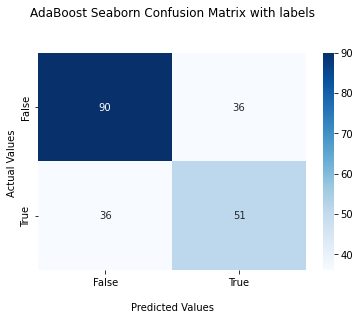

In [63]:
# Create a confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix_ada= confusion_matrix(y_test, predictions_ada)
print(cf_matrix_ada)
import seaborn as sns

ax = sns.heatmap(cf_matrix_ada, annot=True, cmap='Blues')

ax.set_title('AdaBoost Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
#export to image
plt.savefig("pics/adaboost.png",bbox_inches="tight",dpi=220)

# Display the visualization of the Confusion Matrix.
plt.show()

<Figure size 432x288 with 0 Axes>

In [40]:
# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test, predictions_ada, target_names=target_names))

              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       126
         1.0       0.59      0.59      0.59        87

    accuracy                           0.66       213
   macro avg       0.65      0.65      0.65       213
weighted avg       0.66      0.66      0.66       213

